In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq.job import job_monitor
provider = IBMQ.load_account()

/tmp/ipykernel_60/2779030276.py:10: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


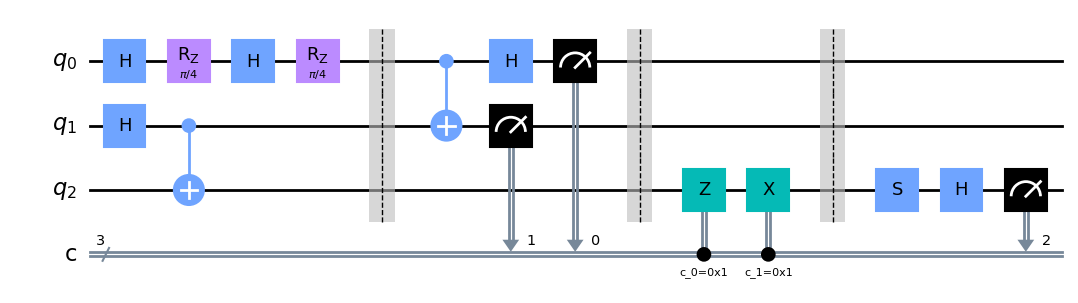

In [26]:
q=3
c=3
#初期状態を作る部分
circ_init = QuantumCircuit(q,c)

#Bell測定の部分
circ_bell = QuantumCircuit(q,c)

#古典通信の部分
circ_comm = QuantumCircuit(q,c)

#測定の部分
meas_x = QuantumCircuit(q,c)
meas_y = QuantumCircuit(q,c)
meas_z = QuantumCircuit(q,c)


#0番目の量子ビットの初期状態を作る
circ_init.h(0)
circ_init.rz(np.pi/4,0)
circ_init.h(0)
circ_init.rz(np.pi/4,0)

#1番目と2番目の量子ビットを完全混合状態にする
circ_init.h(1)
circ_init.cx(1,2)

#Bell測定を行い、結果を古典ビットに入力する
circ_bell.barrier()
circ_bell.cx(0,1)
circ_bell.h(0)
circ_bell.measure([0,1],[0,1])

#古典ビットをもとに3番目のビットを操作する
circ_comm.barrier()
#circ_comm.id(2).c_if(c, 0)
#circ_comm.z(2).c_if(c, 1)
#circ_comm.x(2).c_if(c, 2)
#circ_comm.x(2).c_if(c, 3)
#circ_comm.z(2).c_if(c, 3)

circ_comm.z(2).c_if(0, 1)
circ_comm.x(2).c_if(1, 1)

# x,y,z 測定部をそれぞれ作る
meas_x.barrier()
meas_x.h(2)
meas_x.measure([2],[2])

meas_y.barrier()
meas_y.s(2)
meas_y.h(2)
meas_y.measure([2],[2])

meas_z.barrier()
meas_z.measure([2],[2])

#回路を繋げる
qc_x = circ_init.compose(circ_bell).compose(circ_comm).compose(meas_x)

qc_y = circ_init.compose(circ_bell).compose(circ_comm).compose(meas_y)

qc_z = circ_init.compose(circ_bell).compose(circ_comm).compose(meas_z)

#回路を表示
qc_y.draw(output='mpl')

In [27]:
#シミュレータで試す
simulator = Aer.get_backend('qasm_simulator')

#ショット数、回路の配列、結果の格納庫を用意
shots = 2048
qclist = [qc_x, qc_y, qc_z]
results_sim = []

#回路をシミュレート
for qc in qclist:
    job_sim = execute(qc, backend=simulator, shots=shots)
    results_sim.append(job_sim.result().get_counts(qc))

#各座標の期待値を格納する配列を用意
expectation_values_sim = []

#結果から各座標の期待値を計算
for counts in results_sim:
    n000 = counts.get('000', 0)
    n001 = counts.get('001', 0)
    n010 = counts.get('010', 0)
    n011 = counts.get('011', 0)
    a0 = list(counts.values())
    ntotal = sum(a0)
    expectation_value = (n000 + n001 + n010 + n011) / ntotal
    expectation_values_sim.append(expectation_value)

# 座標 (x,y,z) を表示する
print(expectation_values_sim)


[0.75732421875, 0.744140625, 0.84619140625]
